# Deep Learning for Computer Vision

---

**Goethe University Frankfurt am Main**

Winter Semester 2022/23

<br>

## *Assignment 2 (Classifier)*

---

**Points:** 40<br>
**Due:** 10.11.2022, 10 am<br>
**Contact:** Matthias Fulde ([fulde@cs.uni-frankfurt.de](mailto:fulde@cs.uni-frankfurt.de))<br>

---

**Your Name:** Tilo-Lars Flasche

<br>

#### Note

You should first complete the implementations of the loss and regularization notebooks before starting with this notebook.

<br>

<br>

## Table of Contents

---

- [1 Linear Classifiers](#1-Linear-Classifiers-(40-Points))
  - [1.1 Preprocessing](#1.1-Preprocessing-(5-Points))
  - [1.2 Implementation](#1.2-Implementation-(20-Points))
  - [1.3 Hyperparameter Search](#1.3-Hyperparameter-Search-(10-Points))
  - [1.4 Limitations](#1.4-Limitations-(5-Points))


<br>

## Setup

---

In this notebook we use the libraries **Matplotlib** and **NumPy**.

We want Matplotlib figures to appear within the notebook rather than inside a separate window, which is default in some environments, therefore we make use of the `%matplotlib` magic function to set the Matplotlib backend to inline.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

%matplotlib inline

We import definitions of loss functions from the `loss.py` module, regularizers from the `regularization.py` module, and a utility function to load the CIFAR-10 dataset. We enable autoreload, so that the imported functions are automatically updated whenever the code is changed.

In [ ]:
from data import load_CIFAR_10
from loss import SVM_loss, cross_entropy_loss
from regularization import L1_reg, L2_reg

%load_ext autoreload
%autoreload 2

<br>

## Exercises

---

### 1 Linear Classifiers

---

Having implemented loss functions and regularizers, we now want to implement linear classifiers for the CIFAR-10 dataset that we already used in the previous problem set. Let's start by loading and inspecting the data.

In [3]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_CIFAR_10('datasets/cifar-10-batches-py')

print(
    f'Training data shape: {X_train.shape}',
    f'Training labels shape: {y_train.shape}',
    f'Test data shape: {X_test.shape}',
    f'Test labels shape: {y_test.shape}',
    sep = '\n'
)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


<br>

### 1.1 Preprocessing (5 Points)

---

Before we start implementing and training our classifiers, we have to perform some preprocessing steps on the dataset.

First of all, we want to use some of the images from the training set as our validation set, which we will use to determine the hyperparameters of our models. In addition, we're going to subsample the test set and randomly choose a small training set for development.

In [4]:
# Use 1000 images for the validation set.
indices = np.arange(49000, 50000)
X_val = X_train[indices]
y_val = y_train[indices]

# Use 49000 images for the training set.
indices = np.arange(49000)
X_train = X_train[indices]
y_train = y_train[indices]

# Randomly sample 500 training images for the development set.
indices = np.random.choice(49000, 500, replace=False)
X_dev = X_train[indices]
y_dev = y_train[indices]

# Use 1000 images for the test set.
indices = np.arange(1000)
X_test = X_test[indices]
y_test = y_test[indices]

The linear classifier model expects each input image to be a vector. Hence we transform the images in all four datasets to vectors. So, if there are $N$ images in the respective set, the shape after the transformation will be $(N, D)$ where $D$ is height times width times channels.

In [5]:
# Convert all image tensors into vectors.
X_train, X_val, X_dev, X_test = [
    np.reshape(X, (X.shape[0], -1)) for X in (X_train, X_val, X_dev, X_test)
]

<br>

#### 1.1.1 Normalization (2 Points)

The next step is to normalize the data. We want to center the data in the origin, so the task is to subtract the mean from each image in the four datasets. Compute the mean from the *training set* and use it to normalize all the datasets.

Write your solution in the code cell below.

In [6]:
############################################################
###                  START OF YOUR CODE                  ###
############################################################

# Calculate the mean value for the training dataset
mean_train = X_train.mean()

# Subtract mean value from all datasets
X_train, X_val, X_dev, X_test = [
    X - mean_train for X in (X_train, X_val, X_dev, X_test)
]

############################################################
###                   END OF YOUR CODE                   ###
############################################################

<br>

#### 1.1.3 Implicit Bias (3 Points)

Lastly, we want to simplify the score function of the linear classifier by making the bias implicit. That is, we later want to extend the weight matrix with the bias, so that the prediction of the scores becomes a single matrix multiplication.

To make that work, add a column of ones to each of the four datasets, such that the dimension of the images is $D+1$, with the value $1$ in the *last* dimension of each image. You may loop over the four datasets as we did when turning the image tensors into vectors above, but otherwise use only vectorized operations.

Write your solution in the code cell below.

In [7]:
############################################################
###                  START OF YOUR CODE                  ###
############################################################

# Add a column of ones to each dataset
X_train, X_val, X_dev, X_test = [
    np.concatenate([X, np.ones(X.shape[0]).reshape(-1, 1)], axis=1) for X in (X_train, X_val, X_dev, X_test)
]

############################################################
###                   END OF YOUR CODE                   ###
############################################################

Let's make a sanity check and print out the shapes of the datasets.

In [8]:
# Output the shapes.
print(
    f'Training set shape: {X_train.shape}',
    f'Validation set shape: {X_val.shape}',
    f'Development set shape: {X_dev.shape}',
    f'Test set shape: {X_test.shape}',
    sep = '\n'
)

Training set shape: (49000, 3073)
Validation set shape: (1000, 3073)
Development set shape: (500, 3073)
Test set shape: (1000, 3073)


<br>

### 1.2 Implementation (20 Points)

---

Now we're ready to implement a linear classifier.

Since our data is stored in design matrices with the shape $(N, D+1)$, we define our parameter matrix to have the shape $(D+1, K)$, so that we can compute the scores by

$$
    S = f(X; W) = XW
$$

with S having the shape $(N, K)$, as expected by our loss functions.

<br>

#### 1.2.1 Task

Complete the definitions of the `train` and `predict` methods of the `LinearClassifier` class, using only vectorized operations.

For the `train` method, implement the following steps for stochastic gradient descent:

- Sample randomly and with replacement a mini-batch of input images with corresponding labels from the dataset.
- Compute the scores for the inputs.
- Compute the complete loss and its gradient with respect to the parameters.
- Store the complete loss in the given list for the loss history.
- Update the model parameters with the gradient of the complete loss multiplied by the learning rate.

<br>

Remember that in order to obtain the gradient of the data loss with respect to the parameters, you have to multiply the gradient computed with respect to the scores with the samples of the current mini-batch, using the chain rule for derivatives.

For the `predict` method, implement the following steps:

- Compute the scores for the inputs.
- Return for each sample in the dataset the label for the class with the hightest score.

<br>

#### 1.2.2 Solution

Write your code in the cell below.

In [69]:
class LinearClassifier:

    def __init__(self, K, L, R):
        """
        Create a linear classifier for the given number of classes.

        Parameters:
            - K: Number of classes.
            - L: Data loss.
            - R: Regularization loss.

        """
        self.K = K
        self.L = L
        self.R = R
        self.W = None


    def train(self, X, y, lr=1e-3, reg=1e-5, num_iters=100, batch_size=128, verbose=False, print_every=100):
        """
        Train the linear classifier using stochastic gradient descent.

        Parameters:
            - X: Training images with shape (N, D+1) with number of samples N and data dimension D.
            - y: Training labels for N images.
            - lr: Learning rate.
            - reg: Regularization strength.
            - num_iters: Number of training iterations.
            - batch_size: Number of samples per minibatch.
            - verbose: Show loss during training.
            - print_every: Interval for showing loss.

        Returns:
            - loss_history: List with loss for each iteration.

        """
        N, D = X.shape

        if self.W is None:
            
            # Transpose the parameter matrix to left multiply the dataset.
            self.W = 1e-3 * np.random.randn(D, self.K)

        loss_history = []

        for i in range(num_iters):
            ############################################################
            ###                  START OF YOUR CODE                  ###
            ############################################################
            
            loss = 0.0

            # Iterate over the dataset with mini-batches
            for j in range(X.shape[0] // batch_size):            
                
                # 1. Sample randomly and with replacement a mini-batch of input images with corresponding labels

                # First lets create a list of indices
                indices = np.arange(X.shape[0])

                # Now sample randomly from the list of indices with replacement
                batch_indices = np.random.choice(indices, size=batch_size)

                # Get the batch images and labels
                X_batch, y_batch = X[batch_indices], y[batch_indices]


                # 2. Compute the scores for the input

                # Calculate the score matrix (which will be of dimension BxK, where B is the batch size)
                # (BxD * DxK -> BxK)
                S = X_batch @ self.W
                
                
                # 3. Compute the complete loss and its gradient with respect to the parameters

                # Get the complete loss and its gradient
                L_batch, dS_batch = self.L(S, y_batch)
                
                # Calculate the derivative of the loss function with respect to the weights
                dW = X_batch.T @ dS_batch
                
                # Calculate the regularization term and the derivative of the regularization term with respect to the weights
                R, R_dW = self.R(self.W, reg)
                
                
                # 4. Store the complete loss in the given list

                # save loss
                loss += L_batch + R
                
            
                # 5. Update the model parameters with the gradient of the complete loss multiplied by the learning rate

                # Update parameters
                self.W = self.W - lr * (dW + R_dW)

            loss_history.append(L_batch)
            
            ############################################################
            ###                   END OF YOUR CODE                   ###
            ############################################################
            if verbose and i % print_every == 0:
                print(f'Iteration: {i}/{num_iters} Loss: {loss:.5f}')
                
        return loss_history


    def predict(self, X):
        """
        Predict the labels for a set of test images.

        Parameters:
            - X: Test images with shape (N, D+1) with number of samples N and data dimension D.

        Returns:
            - y_pred: Vector of length N with predictions.

        """
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        y_pred = X @ self.W

        max_exp = np.max(y_pred, axis=1).reshape(-1, 1)
        y_pred = y_pred - max_exp
        
        exp_sum = np.exp(y_pred).sum(axis=1).reshape(-1, 1)
        y_pred = np.exp(y_pred) / exp_sum
        y_pred = np.argmax(y_pred, axis=1)

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################
        return y_pred

<br>

#### 1.2.3 Results

Let's train the model with the cross-entropy loss and L2 regularization and evaluate it both on the training and validation set.

In [70]:
# Create the model.
model = LinearClassifier(10, cross_entropy_loss, L2_reg)

# Train the model for 1000 iterations.
loss_history = model.train(X_train, y_train, num_iters=1000, verbose=True, print_every=10)

# Compute accuracy for the training set.
y_train_pred = model.predict(X_train)
acc_train = np.mean(y_train == y_train_pred)

# Compute accuracy for the validation set.
y_val_pred = model.predict(X_val)
acc_val = np.mean(y_val == y_val_pred)

print(f'Train accuracy: {acc_train*100:.2f}%  |  Validation accuracy: {acc_val*100:.2f}%')

Iteration: 0/1000 Loss: 68593.86599
Iteration: 10/1000 Loss: 64473.30260
Iteration: 20/1000 Loss: 63616.29048
Iteration: 30/1000 Loss: 62405.14964
Iteration: 40/1000 Loss: 62200.83449


KeyboardInterrupt: 

We repeat the steps for the multiclass SVM loss.

In [76]:
# Create the model.
model = LinearClassifier(10, SVM_loss, L2_reg)

# Train the model for 1000 iterations.
loss_history = model.train(X_train, y_train, num_iters=1000, verbose=True, print_every=10)

# Compute accuracy for the training set.
y_train_pred = model.predict(X_train)
acc_train = np.mean(y_train == y_train_pred)

# Compute accuracy for the validation set.
y_val_pred = model.predict(X_val)
acc_val = np.mean(y_val == y_val_pred)

print(f'Train accuracy: {acc_train*100:.2f}%  |  Validation accuracy: {acc_val*100:.2f}%')

Iteration: 0/1000 Loss: 781281.05227


KeyboardInterrupt: 

<br>

### 1.3 Hyperparameter Search (10 Points)

---

In order to find out which values for the *learning rate* and the *regularization strength* work good for our data, we want to perform a hyperparameter search.

<br>

#### 1.3.1 Task

Choose one of the loss functions and tune the hyperparameters of the model on the validation set, using L2 regularization.

Experiment with different ranges for the learning rate and the regularization strength. For each combination compute the accuracy on the validation set. Store the accuracies in the `results` array, such that the indices $(i, j)$ correspond to the $i$-th learning rate and $j$-th regularization strength from the candidate lists which are defined below. Sort the candidate values in ascending order for an interpretable visualization.

In order to save computation time, start with a coarse selection of four to five values for each hyperparameter. You can check the results with the code given below to refine the search.

You should be able to get $> 35\%$ accuracy on the test set.

<br>

#### 1.3.2 Solution

Write your solution in the cell below.

In [78]:
# Define candidate values in ascending order.
lrs = [1e-4, 1e-3, 1e-2, 1e-1]
regs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Create array to store results.
results = np.empty((len(lrs), len(regs)))

############################################################
###                  START OF YOUR CODE                  ###
############################################################

for i, lr in enumerate(lrs):
    for j, reg in enumerate(regs):
        # Print some logging statement
        print(f"Training model: lr={lr}, reg={reg}")
        
        # Train the model for 1000 iterations.
        loss_history = model.train(X_train, y_train, lr=lr, reg=reg, num_iters=1000, verbose=True, print_every=100)

        # Compute accuracy for the validation set.
        y_val_pred = model.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        # Save the accuracy for the tested parameters
        results[i][j] = acc_val
        
############################################################
###                   END OF YOUR CODE                   ###
############################################################

# Get best accuracy.
best_acc = np.max(results)

# Get indices of the best values.
i, j = np.unravel_index(np.argmax(results), results.shape)

# Save the best values.
best_lr = lrs[i]
best_reg = regs[j]

# Show result.
print(f'Best validation accuracy: {best_acc*100:.2f}% with lr = {best_lr} and reg = {best_reg}')

Training model: lr=0.0001, reg=1e-05
Iteration: 0/1 Loss: 116991.38714
Training model: lr=0.0001, reg=0.0001
Iteration: 0/1 Loss: 111638.51179
Training model: lr=0.0001, reg=0.001
Iteration: 0/1 Loss: 106232.90158
Training model: lr=0.0001, reg=0.01
Iteration: 0/1 Loss: 102893.54085
Training model: lr=0.0001, reg=0.1
Iteration: 0/1 Loss: 110605.69646
Training model: lr=0.001, reg=1e-05
Iteration: 0/1 Loss: 721142.72615
Training model: lr=0.001, reg=0.0001
Iteration: 0/1 Loss: 676998.67827
Training model: lr=0.001, reg=0.001
Iteration: 0/1 Loss: 661712.55317
Training model: lr=0.001, reg=0.01
Iteration: 0/1 Loss: 657799.65831
Training model: lr=0.001, reg=0.1
Iteration: 0/1 Loss: 677721.26655
Training model: lr=0.01, reg=1e-05
Iteration: 0/1 Loss: 7681079.31265
Training model: lr=0.01, reg=0.0001
Iteration: 0/1 Loss: 7207179.96855
Training model: lr=0.01, reg=0.001
Iteration: 0/1 Loss: 7002454.72908
Training model: lr=0.01, reg=0.01
Iteration: 0/1 Loss: 7132215.84350
Training model: lr=

Let's visualize the results of the grid search to get an idea which values worked better or worse.

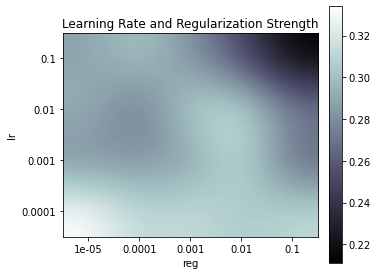

In [79]:
# Create figure.
plt.figure(figsize=(5,5))

# Set title and axis labels.
plt.title('Learning Rate and Regularization Strength')
plt.xlabel('reg')
plt.ylabel('lr')

# Reverse order of entries.
res = np.flip(results, axis=0)

# Set axis ticks.
plt.xticks(ticks=np.arange(len(regs)), labels=regs)
plt.yticks(ticks=np.arange(len(lrs)), labels=list(reversed(lrs)))

# Show accuracies as heat map.
plt.colorbar(plt.imshow(res, cmap='bone', interpolation='bicubic'), ax=plt.gca(), fraction=0.046, pad=0.04)
plt.show()

<br>

#### 1.3.3 Result

Now let's evaluate the best model on the test set. Change the loss function if you worked with the SVM loss.

In [83]:
# Create the model.
model = LinearClassifier(10, cross_entropy_loss, L2_reg)

# Train the model for some more iterations.
loss_history = model.train(X_train, y_train, best_lr, best_reg, num_iters=2_000)

# Compute accuracy for the training set.
y_train_pred = model.predict(X_train)
acc_train = np.mean(y_train == y_train_pred)

# Compute accuracy for the test set.
y_test_pred = model.predict(X_test)
acc_test = np.mean(y_test == y_test_pred)

print(f'Train accuracy: {acc_train*100:.2f}%  |  Test accuracy: {acc_test*100:.2f}%')

Train accuracy: 28.99%  |  Test accuracy: 26.20%


Finaly make a plot with the losses computed during training.

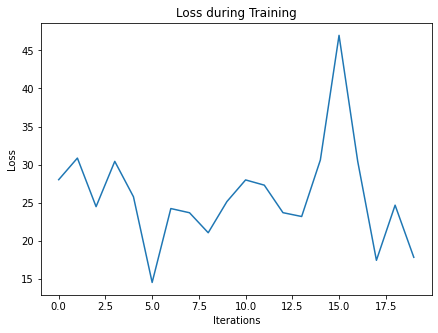

In [84]:
# Create figure.
plt.figure(figsize=(7,5))

# Set title and axis labels.
plt.title('Loss during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plot the loss.
plt.plot(np.array(loss_history))
plt.show()

<br>

### 1.4 Limitations (5 Points)

---

Give a concise description of the limitations of the linear classifer for image classification. What are the shortcomings of this model preventing it from attaining a high accuracy on natural images? Take into account the different interpretations of the role of the model's parameters.

<br>

##### Answer

*Write your answer here.*

<br>

### Acknowledgement

Parts of this exercise are adapted from the Stanford CS231n course.